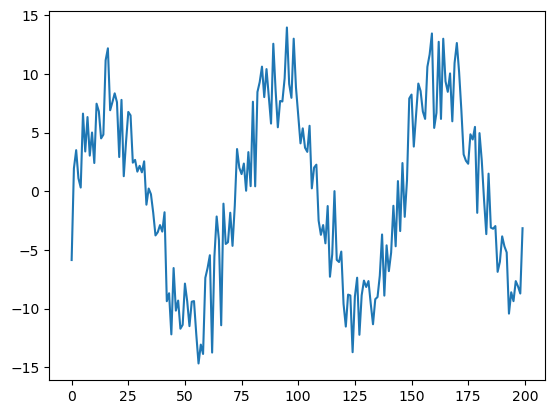

In [221]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
import matplotlib.pyplot as plt
# ----------------------------
# 1. Synthetic Data Generation with Linear Trend, Distance-Dependent Seasonal Variability
# ----------------------------

np.random.seed(42)  # For reproducibility

n_days = 200  # Total number of time points (731 days, 2 years of data)

# Generate "day of the year" feature as integers (2 years)
time_feature = np.arange(1, n_days + 1).reshape(-1, 1)  # Shape: (731, 1)

# Define spatial coordinates for the stations (1 target + 5 nearby)
num_stations = 6
station_coords = {}
for i in range(num_stations):
    if i == 0:
        station_coords[f'station_{i}'] = {'x': 0.0, 'y': 0.0}  # Target station at (0,0)
    else:
        station_coords[f'station_{i}'] = {'x': np.random.uniform(-10, 10), 'y': np.random.uniform(-10, 10)}  # Random nearby stations

# Function to compute the distance from the target station (used for seasonal variability)
def compute_distance_from_target(x, y):
    return np.sqrt(x**2 + y**2)

# Function to generate temperature data with linear trend and distance-dependent seasonal variability
def generate_temperature(time_feature, x, y, base_temp=20, noise_scale=2, interannual_scale=3, seasonal_amplitude=10, trend_rate=0.01):
    distance = compute_distance_from_target(x, y)  # Distance from the target station
    trend = trend_rate * time_feature.flatten()  # Linear trend component
    
    # Seasonal component (amplitude grows with distance from the target station)
    seasonal_variability = (seasonal_amplitude + distance * 0.5) * np.sin(2 * np.pi * time_feature.flatten() / (365.25 * 0.2))
    
    # Interannual variability: gradual year-to-year changes
    interannual_variability = interannual_scale * np.sin(2 * np.pi * time_feature.flatten() / (365.25 * 2))
    
    # Random noise
    noise = np.random.normal(0, noise_scale, n_days)
    
    # Total temperature = base temperature + trend + seasonal + interannual + noise
    return base_temp + trend + seasonal_variability + interannual_variability + noise

# Generate temperature data for all stations
temperature_data = {}
mean_temps = {}
std_temps = {}

for i in range(num_stations):
    station_name = f'station_{i}'
    x = station_coords[station_name]['x']
    y = station_coords[station_name]['y']
    
    if i == 0:
        # Target station has a larger seasonal amplitude and interannual variability
        temp = generate_temperature(time_feature, x, y, base_temp=22, noise_scale=2, interannual_scale=5, seasonal_amplitude=15, trend_rate=0.05)
        
        # Introduce missing data in the target station
        def create_gap_chunks(n_points, ngaps, chunk_size):
            gap_starts = np.sort(np.random.choice(n_points - chunk_size, ngaps, replace=False))
            gap_indices = np.concatenate([np.arange(start, start + chunk_size) for start in gap_starts])
            return gap_indices
        
        ngaps = 2  # Number of missing gaps
        chunk_size = 90  # Size of each missing chunk
        gap_indices = create_gap_chunks(n_days, ngaps, chunk_size)
        temp_with_gaps = temp.copy()
        temp_with_gaps[gap_indices] = np.nan
        temperature_data[station_name] = temp_with_gaps
    else:
        # Nearby stations have different base temperatures, seasonal variability, and interannual variability
        temp = generate_temperature(time_feature, x, y, base_temp=20 + np.random.uniform(-2, 2),
                                    noise_scale=2 + np.random.uniform(-0.5, 0.5),
                                    interannual_scale=2 + np.random.uniform(-1, 1),
                                    seasonal_amplitude=8 + np.random.uniform(-2, 2),
                                    trend_rate=0.01 + np.random.uniform(-0.005, 0.005))  # Small trend variation
        temperature_data[station_name] = temp.copy()
    
    # Standardize temperature data for each station (excluding missing data)
    observed_indices = ~np.isnan(temperature_data[station_name])
    mean_temp = np.mean(temperature_data[station_name][observed_indices])
    # std_temp = np.std(temperature_data[station_name][observed_indices])
    std_temp = 1.

    mean_temps[station_name] = mean_temp
    std_temps[station_name] = std_temp
    temperature_data[station_name][observed_indices] = (temperature_data[station_name][observed_indices] - mean_temp) / std_temp
plt.plot(temperature_data[station_name])

In [222]:
# ----------------------------
# 2. Compute Distances from Target Station to Nearby Stations
# ----------------------------

distances = {}  # Dictionary to store distances from target station to each nearby station

target_coords = station_coords['station_0']  # Coordinates of the target station

# Compute the Euclidean distance from the target station to each nearby station
for i in range(1, num_stations):
    station_name = f'station_{i}'
    nearby_coords = station_coords[station_name]
    distance = np.sqrt((target_coords['x'] - nearby_coords['x'])**2 + (target_coords['y'] - nearby_coords['y'])**2)
    distances[station_name] = distance


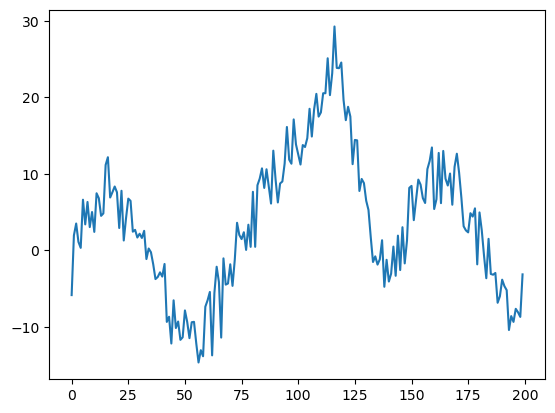

In [223]:
# ----------------------------
# 2. Introduce Smooth Temperature Pulse in Nearby Stations during Target Station Gap
# ----------------------------

# Function to create a Gaussian-shaped pulse with a smooth decay
def create_gaussian_pulse(length, amplitude, std_dev):
    center = length // 2
    return amplitude * np.exp(-0.5 * ((np.arange(length) - center) / std_dev)**2)

# Maximum amplitude and standard deviation for the pulse
pulse_amplitude =15  # Max temperature of the pulse
pulse_std_dev = 10  # Controls the width of the pulse

# Loop over each nearby station and apply a pulse to each gap
for i in range(1, num_stations):  # Apply only to nearby stations
    station_name = f'station_{i}'
    
    # Loop over each gap and apply the pulse
    for start in np.split(gap_indices, np.where(np.diff(gap_indices) != 1)[0] + 1):
        gap_length = len(start)
        
        # Generate the smooth pulse for the length of this specific gap
        pulse = create_gaussian_pulse(gap_length, amplitude=pulse_amplitude, std_dev=pulse_std_dev)
        
        # Apply the pulse to the temperature data for this gap
        temperature_data[station_name][start] += pulse

plt.plot(temperature_data[station_name])

In [252]:
# ----------------------------
# 3. Feature Preparation and GPR Model Training
# ----------------------------
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C

# Prepare features (time and space) and target variables (temperature) for GPR model
X_list = []
y_list = []
for i in range(num_stations):
    station_name = f'station_{i}'
    x = station_coords[station_name]['x']
    y = station_coords[station_name]['y']
    temp = temperature_data[station_name]
    
    # Time feature
    time_feat = time_feature.copy()
    
    # Spatial features
    spatial_feat = np.tile([x, y], (n_days, 1))  # Shape: (731, 2)
    
    # Combine features (time, spatial) and store temperature data
    X_station = np.hstack([time_feat, spatial_feat])  # Shape: (731, 3)
    y_station = temp.reshape(-1, 1)  # Shape: (731, 1)
    
    # Collect data (exclude missing values)
    observed_indices = ~np.isnan(y_station).flatten()
    X_list.append(X_station[observed_indices])
    y_list.append(y_station[observed_indices])

# Combine data from all stations for GPR model training
X_train = np.vstack(X_list)
y_train = np.vstack(y_list).flatten()

# Define the kernel for GPR with separate length scales for time, x, and y
# kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-2, 1e3), nu=1.5) + WhiteKernel(noise_level=0.2, noise_level_bounds=(1e-5, 0.5))

# Initialize and train the Gaussian Process Regressor (GPR)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=0, normalize_y=False)
print("Training Gaussian Process Regressor...")
gp.fit(X_train, y_train)

Training Gaussian Process Regressor...


/Users/anthonymeza/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.5. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=0,
                         kernel=1**2 * Matern(length_scale=[1, 1, 1], nu=1.5) + WhiteKernel(noise_level=0.2),
                         n_restarts_optimizer=5)

In [253]:
print("Initial kernel parameters:")
print(gp.kernel.get_params())

print("\nOptimized kernel parameters:")
print(gp.kernel_)

Initial kernel parameters:
{'k1': 1**2 * Matern(length_scale=[1, 1, 1], nu=1.5), 'k2': WhiteKernel(noise_level=0.2), 'k1__k1': 1**2, 'k1__k2': Matern(length_scale=[1, 1, 1], nu=1.5), 'k1__k1__constant_value': 1.0, 'k1__k1__constant_value_bounds': (0.001, 1000.0), 'k1__k2__length_scale': [1.0, 1.0, 1.0], 'k1__k2__length_scale_bounds': (0.01, 1000.0), 'k1__k2__nu': 1.5, 'k2__noise_level': 0.2, 'k2__noise_level_bounds': (1e-05, 0.5)}

Optimized kernel parameters:
7.63**2 * Matern(length_scale=[2.34, 13.2, 8.16], nu=1.5) + WhiteKernel(noise_level=0.5)


In [254]:
# ----------------------------
# 4. Prediction for Target Station using GPR
# ----------------------------

# Prepare features for the target station (entire time series)
station_name = 'station_0'  # Target station
x = station_coords[station_name]['x']
y = station_coords[station_name]['y']

# Time feature for the target station
time_feat = time_feature.copy()

# Spatial features (x, y) for the target station
spatial_feat = np.tile([x, y], (n_days, 1))  # Shape: (731, 2)

# Combine features (time, x, y) for the target station
X_target = np.hstack([time_feat, spatial_feat])  # Shape: (731, 3)

# Predict temperature for the target station (including the gaps)
print("Predicting temperature for the target station...")
y_pred_scaled, y_std = gp.predict(X_target, return_std = True)

Predicting temperature for the target station...


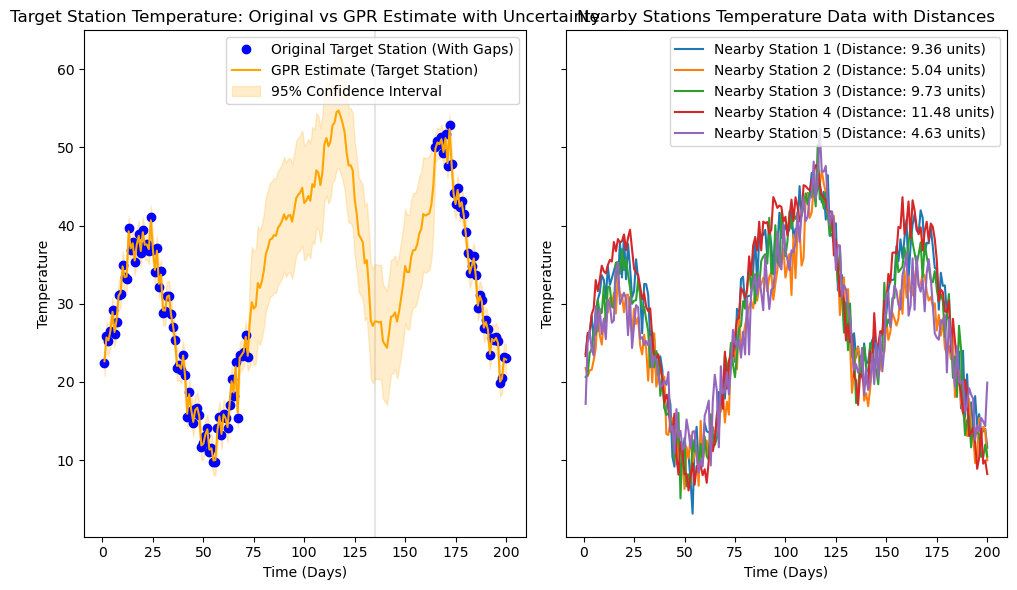

In [255]:
# ----------------------------
# 5. Visualization: Plot Original Data, GPR Estimates, and Nearby Stations with Distances
# ----------------------------

# Flatten time_feature to ensure it's 1D for plotting
time_feature_flat = time_feature.flatten()

# Create figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey = True)

# ----------------------------
# Plot 1: Target Station (with GPR estimate, original data, and uncertainty)
# ----------------------------

# For the target station, plot the full time series (with gaps)
temperature_target_with_gaps = temperature_data['station_0'].copy()
temperature_target_with_gaps[~np.isnan(temperature_target_with_gaps)] = (
    temperature_target_with_gaps[~np.isnan(temperature_target_with_gaps)] * std_temps['station_0'] + mean_temps['station_0']
)

# Plot the original data from the target station (including gaps)
ax[0].plot(time_feature_flat, temperature_target_with_gaps, label='Original Target Station (With Gaps)', color='blue', marker='o', linestyle='None')

# Plot the GPR estimate for the entire time series (including the filled gaps)
y_pred = y_pred_scaled * std_temps['station_0'] + mean_temps['station_0']  # Rescale the GPR prediction
ax[0].plot(time_feature_flat, y_pred, label='GPR Estimate (Target Station)', color='orange')

# Plot the GPR uncertainty (±1.96 * standard deviation)
y_std_rescaled = y_std * std_temps['station_0']  # Rescale the GPR standard deviation
ax[0].fill_between(time_feature_flat, y_pred - 1.96 * y_std, y_pred + 1.96 * y_std, color='orange', alpha=0.2, label='95% Confidence Interval')

# Labels and title for the target station plot
ax[0].set_xlabel('Time (Days)')
ax[0].set_ylabel('Temperature')
ax[0].set_title('Target Station Temperature: Original vs GPR Estimate with Uncertainty')
ax[0].legend()

# ----------------------------
# Plot 2: Nearby Stations Data (Full Record with Distances)
# ----------------------------

# Plot the temperature time series for nearby stations
for i in range(1, num_stations):
    station_name = f'station_{i}'
    mean_temp = mean_temps[station_name]
    std_temp = std_temps[station_name]
    
    # Convert the standardized temperatures back to the original scale
    temp_original_scale = temperature_data[station_name] * std_temp + mean_temp
    
    # Plot the entire record for each nearby station, adding the distance to the label
    ax[1].plot(time_feature_flat, temp_original_scale, label=f'Nearby Station {i} (Distance: {distances[station_name]:.2f} units)', linestyle='-')

# Labels and title for the nearby stations plot
ax[1].set_xlabel('Time (Days)')
ax[1].set_ylabel('Temperature')
ax[1].set_title('Nearby Stations Temperature Data with Distances')
ax[1].legend()

# Define the pulse midpoint (center of the gap in the target station's data)
pulse_midpoint = 135

ax[0].axvline(pulse_midpoint, 0, 1, color = "grey", alpha = 0.2, zorder = 0)
# Adjust layout and show the plots
plt.tight_layout()
plt.show()

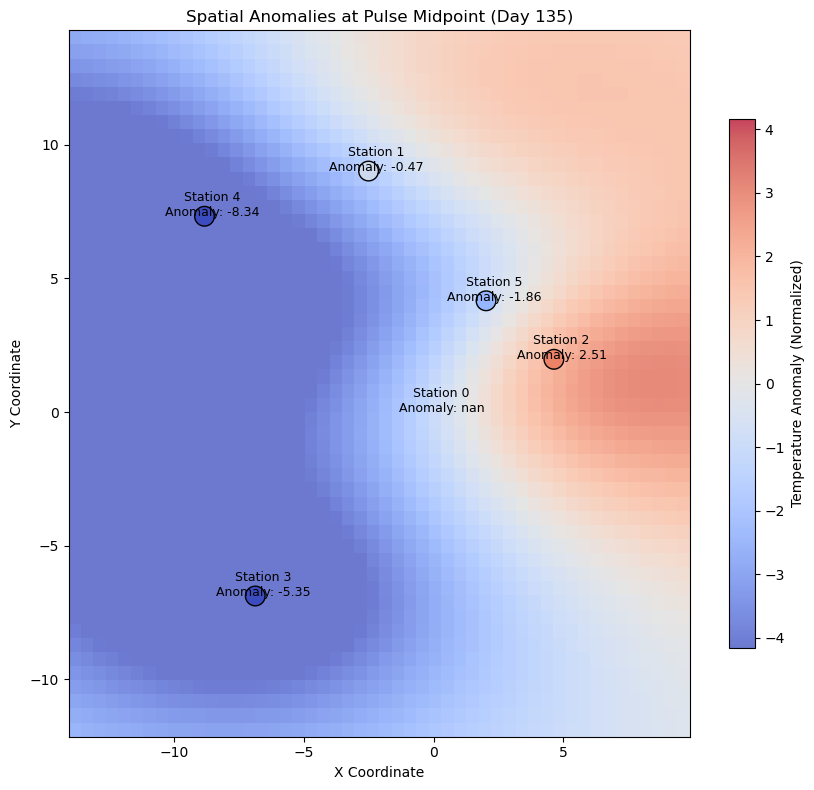

In [257]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# ----------------------------
# Interpolated Spatial Anomaly Plot Using GPR at the Pulse Midpoint (with Scatter and Contour)
# ----------------------------

# Define the spatial grid where we will interpolate the temperature field
grid_size = 50  # Define the resolution of the grid (e.g., 50x50)
x_min, x_max = min(x_coords) - 5, max(x_coords) + 5  # Expand the grid slightly beyond the stations
y_min, y_max = min(y_coords) - 5, max(y_coords) + 5

# Create a meshgrid over the spatial domain
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, grid_size), np.linspace(y_min, y_max, grid_size))

# Flatten the grid coordinates to create the feature matrix for GPR prediction
grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T  # Shape: (grid_size^2, 2)

# For GPR prediction, we need to add the time feature (at the pulse midpoint)
time_at_pulse = np.full((grid_points.shape[0], 1), pulse_midpoint)  # Shape: (grid_size^2, 1)

# Combine the time and spatial features for the grid
X_grid = np.hstack([time_at_pulse, grid_points])  # Shape: (grid_size^2, 3)

# Predict the normalized temperature anomaly at each grid point using GPR
y_grid_pred_anomaly, y_grid_std = gp.predict(X_grid, return_std=True)

# Reshape the predictions back to the grid shape for plotting
y_grid_pred_anomaly_reshaped = y_grid_pred_anomaly.reshape(grid_size, grid_size)

# Normalize the station temperatures to anomalies
spatial_temperatures_anomaly = []
for i in range(num_stations):
    station_name = f'station_{i}'
    mean_temp = mean_temps[station_name]
    std_temp = std_temps[station_name]
    
    # Take the temperature at the pulse midpoint and normalize it
    temp_at_pulse = temperature_data[station_name][pulse_midpoint]
    spatial_temperatures_anomaly.append(temp_at_pulse)

# ----------------------------
# Plotting the Scatter and Contour Plot with Shared Colorbar
# ----------------------------

plt.figure(figsize=(10, 8))

# Find symmetric color limits (use the max absolute value to make the colorbar symmetric)
vmax = max(np.nanmax(np.abs(spatial_temperatures_anomaly)), np.nanmax(np.abs(y_grid_pred_anomaly_reshaped)))
vmax = vmax/2


# Create a contour plot for the interpolated temperature anomaly field
contour = plt.pcolormesh(grid_x, grid_y, y_grid_pred_anomaly_reshaped, cmap='coolwarm', vmin = -vmax, vmax = vmax, alpha=0.75)

# Overlay the station locations with their normalized anomalies
scatter = plt.scatter(x_coords, y_coords, c=spatial_temperatures_anomaly, cmap='coolwarm', s=200, edgecolor='k', vmin = -vmax, vmax = vmax, label='Stations')

# Add color bar to show the temperature anomaly scale (shared between contour and scatter)
cbar = plt.colorbar(contour, label='Temperature Anomaly (Normalized)', shrink=0.75)

# Annotate each point with its station number and temperature anomaly value
for i in range(num_stations):
    plt.text(x_coords[i] + 0.3, y_coords[i], f'Station {i}\nAnomaly: {spatial_temperatures_anomaly[i]:.2f}', fontsize=9, ha='center')

# Set plot labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Spatial Anomalies at Pulse Midpoint (Day {pulse_midpoint})')

# Adjust layout to prevent clipping
plt.tight_layout()
plt.subplots_adjust(right=0.85)

# Show the plot
plt.show()
